Computing embeddings for the new images: ['new_images/view2.jpg', 'new_images/view.jpg', 'new_images/texture.jpg', 'new_images/pengu.jpg', 'new_images/bunny.jpg']
Embeddings computed.
Finding top similar images...
Top similar images: ['5375a54c-347f-4e04-aeba-8f118025b7e1', '658a4d44-b294-41e3-a048-8af8d0d99040', 'd062a0cf-84bb-4234-a376-47020e41c42c', '665d1466-dfca-4b6b-9aaf-272e833a207f', 'd2a11710-86e6-4912-b228-d2b00e34d9e5']
Loading image paths from the database...
Image paths loaded: {'658a4d44-b294-41e3-a048-8af8d0d99040': 'E:/data/image_data\\coco2017_unlabeled\\unlabeled2017\\000000114260.jpg', 'd2a11710-86e6-4912-b228-d2b00e34d9e5': 'E:/data/image_data\\pexels_dataset_v1\\images_03\\green-forest-under-cloudy-sky-821944.jpeg', '665d1466-dfca-4b6b-9aaf-272e833a207f': 'E:/data/image_data\\pexels_dataset_v1\\images_05\\rocks-on-body-of-water-10547.jpeg', '5375a54c-347f-4e04-aeba-8f118025b7e1': 'E:/data/image_data\\pixabay_dataset_v1\\images_02\\clouds-atmosphere-great-beautiful-

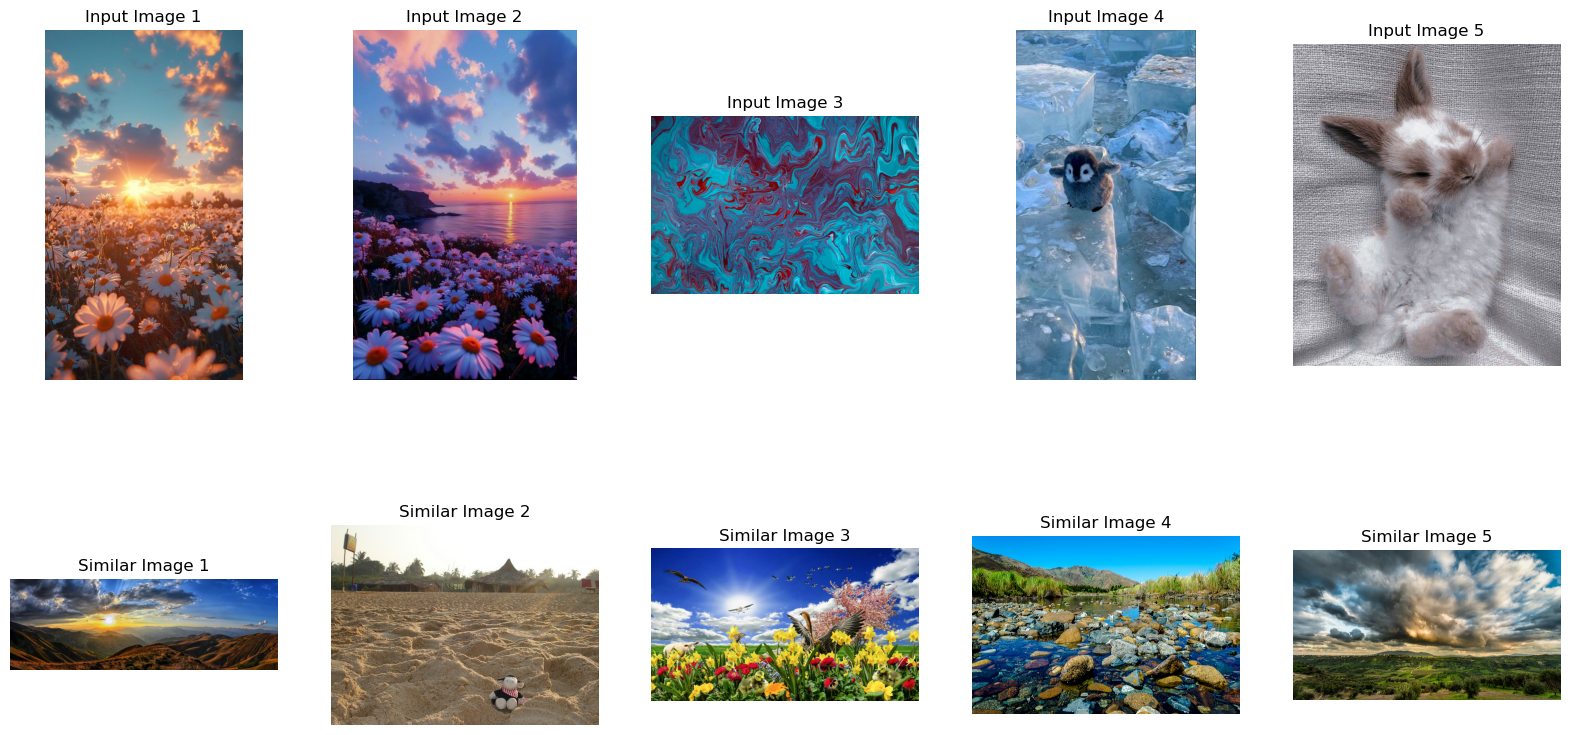

Images plotted.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sqlite3
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torchvision import models, transforms
from PIL import Image

# Load pre-trained ResNet model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove the last layer
model.eval()

# Define image preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_embeddings_in_batches(file_path, batch_size):
    with open(file_path, 'rb') as f:
        data = pd.read_pickle(f)
    uuids = list(data.keys())
    embeddings = list(data.values())
    for i in range(0, len(embeddings), batch_size):
        yield uuids[i:i + batch_size], embeddings[i:i + batch_size]

def compute_embedding(img_path, model):
    img = Image.open(img_path).convert('RGB')
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        embedding = model(img_tensor)
    embedding = embedding.view(-1).numpy()  # Flatten the embedding
    return embedding

def compute_multiple_embeddings(img_paths, model):
    embeddings = []
    for img_path in img_paths:
        embedding = compute_embedding(img_path, model)
        embeddings.append(embedding)
    return np.mean(embeddings, axis=0)  # Average the embeddings

def find_top_similar_images(embedding, embeddings_batches, top_n=5):
    all_similarities = []
    all_uuids = []
    
    for uuids_batch, embeddings_batch in embeddings_batches:
        similarities = cosine_similarity([embedding], embeddings_batch)[0]
        all_similarities.extend(similarities)
        all_uuids.extend(uuids_batch)
    
    all_similarities = np.array(all_similarities)
    top_indices = all_similarities.argsort()[-top_n:][::-1]
    return [all_uuids[i] for i in top_indices]

def load_image_paths_from_db(db_path, uuids):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    placeholders = ', '.join(['?'] * len(uuids))
    query = f"SELECT uuid, file_path FROM images WHERE uuid IN ({placeholders})"
    cursor.execute(query, uuids)
    rows = cursor.fetchall()
    conn.close()
    return {row[0]: row[1] for row in rows}

def plot_images(main_image_paths, top_similar_images_paths):
    plt.figure(figsize=(20, 10))
    
    for i, img_path in enumerate(main_image_paths):
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Input image not found at path: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f'Input Image {i+1}')
        plt.axis('off')
    
    for i, img_path in enumerate(top_similar_images_paths):
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Similar image not found at path: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 5, i + 6)
        plt.imshow(img)
        plt.title(f'Similar Image {i+1}')
        plt.axis('off')
    
    plt.show()

# Example usage
input_images = ["new_images/view2.jpg","new_images/view.jpg","new_images/texture.jpg","new_images/pengu.jpg","new_images/bunny.jpg"]  # Paths to the input images
cosine_similarities_path = "combined_embeddings.pkl"  # Path to precomputed dataset embeddings
database_path = "image_metadata.db"  # Path to the database
batch_size = 1000  # Adjust batch size according to memory capacity
multiple_inputs = len(input_images) > 1

# Compute embedding for the new image(s)
if multiple_inputs:
    print(f"Computing embeddings for the new images: {input_images}")
    new_image_embedding = compute_multiple_embeddings(input_images, model)
    print("Embeddings computed.")
else:
    print(f"Computing embedding for the new image: {input_images[0]}")
    new_image_embedding = compute_embedding(input_images[0], model)
    print("Embedding computed.")

# Load embeddings in batches and find top similar images
print("Finding top similar images...")
embeddings_batches = load_embeddings_in_batches(cosine_similarities_path, batch_size)
top_similar_images = find_top_similar_images(new_image_embedding, embeddings_batches)
print(f"Top similar images: {top_similar_images}")

# Load image paths from the database
print("Loading image paths from the database...")
image_paths_dict = load_image_paths_from_db(database_path, top_similar_images)
print(f"Image paths loaded: {image_paths_dict}")

# Get the paths for the similar images
top_similar_images_paths = [image_paths_dict[uuid] for uuid in top_similar_images]
print(f"Top similar images paths: {top_similar_images_paths}")

# Plot the images
print("Plotting images...")
plot_images(input_images, top_similar_images_paths)
print("Images plotted.")


Computing average histogram for the new images: ['new_images/try.jpg', 'new_images/view.jpg', 'new_images/texture.jpg', 'new_images/pengu.jpg', 'new_images/new_try2.jpg']


100%|██████████| 890/890 [00:01<00:00, 598.92it/s]


Top similar images using correlation method: ['b9cd9c41-dce5-4cd6-b030-a894b34b805d', '9043e208-9053-4496-9c3d-575ceec00b3c', 'db709997-1027-4438-b32a-ccfb630263bd', 'f43575e9-864d-48e2-a52b-79a9a25ff19f', 'd64c9ecb-ae3c-41d4-9f36-402f88718620']


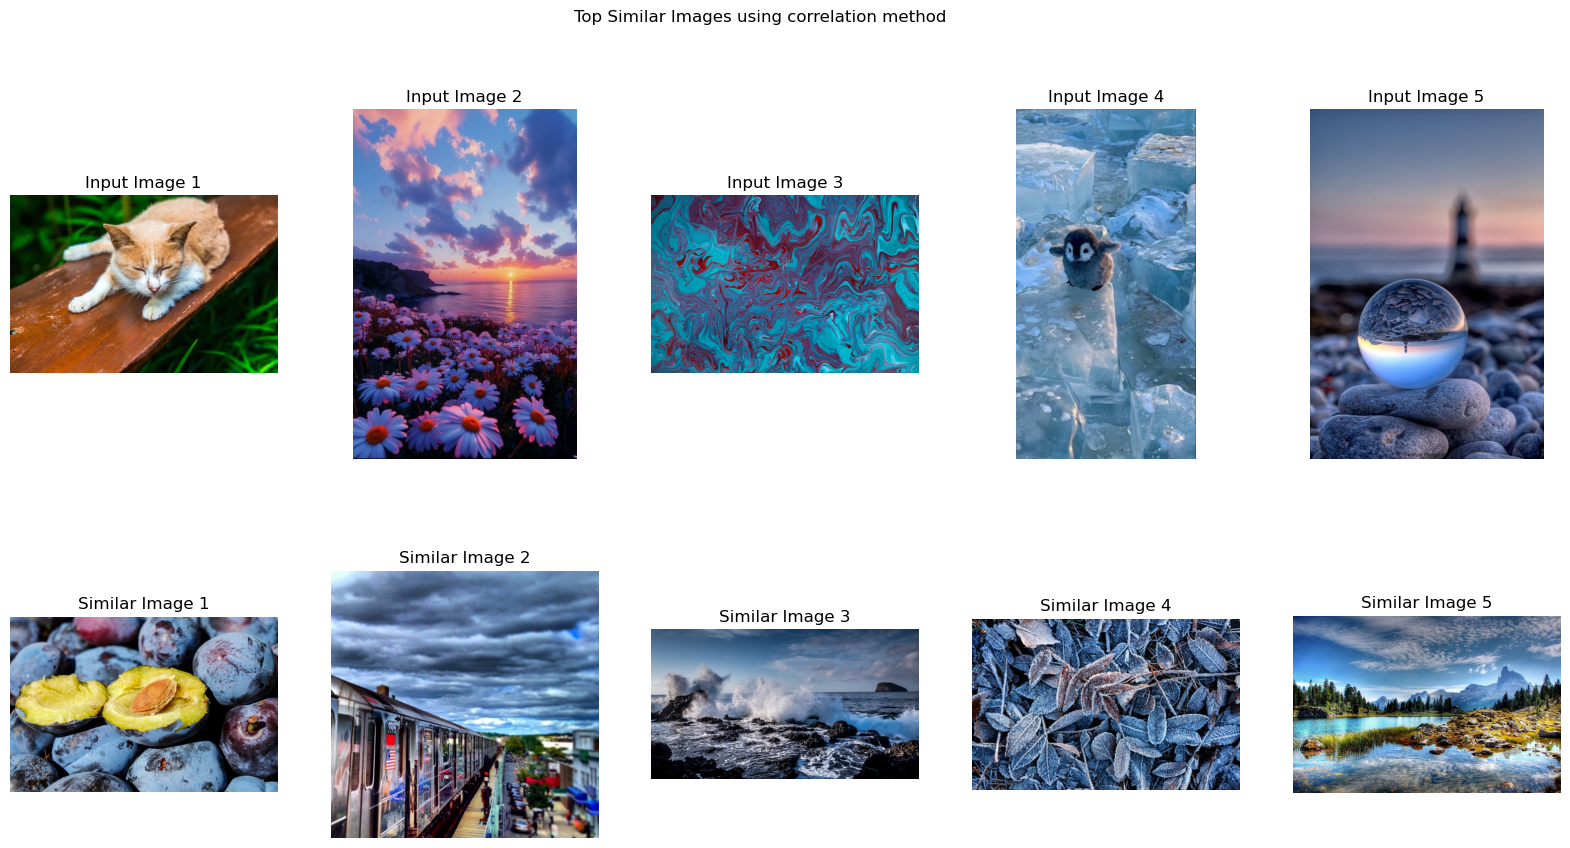

In [16]:
import os
import pickle
import sqlite3
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the histograms from the pickle file
def load_histograms(pickle_file):
    with open(pickle_file, 'rb') as f:
        histograms = pickle.load(f)
    return histograms

# Compare histograms using different methods
def compare_histograms(hist1, hist2, method='correlation'):
    if hist1.shape != hist2.shape:
        raise ValueError("Histograms must have the same shape for comparison.")
    
    if method == 'correlation':
        return cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    elif method == 'chi-square':
        return cv2.compareHist(hist1, hist2, cv2.HISTCMP_CHISQR)
    elif method == 'intersection':
        return cv2.compareHist(hist1, hist2, cv2.HISTCMP_INTERSECT)
    elif method == 'bhattacharyya':
        return cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)

# Preprocess histogram to ensure consistent shape
def preprocess_histogram(image, bin_size=(16, 16, 16), ranges=[0, 256, 0, 256, 0, 256]):
    hist = cv2.calcHist([image], [0, 1, 2], None, bin_size, ranges)
    cv2.normalize(hist, hist)
    return hist.flatten()

# Compute the average histogram for multiple input images
def compute_average_histogram(image_paths):
    histograms = []
    for img_path in image_paths:
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Unable to read image at path {img_path}")
        hist = preprocess_histogram(image)
        histograms.append(hist)
    return np.mean(histograms, axis=0)

# Find the top similar images
def find_top_color_similar_images(target_hist, histograms, top_n=5, method='correlation', batch_size=500):
    all_uuids = list(histograms.keys())
    similarities = []

    # Process in batches
    for i in tqdm(range(0, len(all_uuids), batch_size)):
        batch_uuids = all_uuids[i:i+batch_size]
        batch_histograms = [histograms[uuid] for uuid in batch_uuids]
        batch_similarities = []
        for hist in batch_histograms:
            try:
                similarity = compare_histograms(target_hist, hist, method)
                batch_similarities.append(similarity)
            except ValueError as e:
                print(f"Error comparing histograms: {e}")
                batch_similarities.append(float('-inf') if method in ['correlation', 'intersection'] else float('inf'))
        similarities.extend(batch_similarities)

    # For 'correlation' and 'intersection', higher score means more similar; for others, lower score means more similar
    if method in ['correlation', 'intersection']:
        top_similar_indices = np.argsort(similarities)[-top_n:]
    else:
        top_similar_indices = np.argsort(similarities)[:top_n]
    
    top_similar_uuids = [all_uuids[idx] for idx in top_similar_indices]
    return top_similar_uuids

# Plot images
def plot_images(input_image_paths, similar_image_paths, method):
    num_input_images = len(input_image_paths)
    fig, axes = plt.subplots(2, max(num_input_images, len(similar_image_paths)), figsize=(20, 10))

    for i, img_path in enumerate(input_image_paths):
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        axes[0, i].imshow(img)
        axes[0, i].set_title(f'Input Image {i+1}')
        axes[0, i].axis('off')

    for i, img_path in enumerate(similar_image_paths):
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        axes[1, i].imshow(img)
        axes[1, i].set_title(f'Similar Image {i+1}')
        axes[1, i].axis('off')

    plt.suptitle(f'Top Similar Images using {method} method')
    plt.show()

# Load image paths from the database
def load_image_paths_from_db(db_path, uuids):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    placeholders = ', '.join(['?'] * len(uuids))
    query = f"SELECT uuid, file_path FROM images WHERE uuid IN ({placeholders})"
    cursor.execute(query, uuids)
    rows = cursor.fetchall()
    conn.close()
    return {row[0]: row[1] for row in rows}

def main():
    pickle_file = "combined_color_histograms.pkl"  # Replace with your actual file path
    input_image_paths = ["new_images/try.jpg","new_images/view.jpg","new_images/texture.jpg","new_images/pengu.jpg","new_images/new_try2.jpg"]  # Replace with your actual input image paths
    database_path = "image_metadata.db" 
    
    # Load the histograms from the pickle file
    histograms = load_histograms(pickle_file)

    # Compute the average histogram for the input images
    if len(input_image_paths) > 1:
        print(f"Computing average histogram for the new images: {input_image_paths}")
        target_hist = compute_average_histogram(input_image_paths)
    else:
        print(f"Computing histogram for the new image: {input_image_paths[0]}")
        input_image = cv2.imread(input_image_paths[0])
        if input_image is None:
            raise ValueError(f"Unable to read image at path {input_image_paths[0]}")
        target_hist = preprocess_histogram(input_image)

    # Find top similar images for different methods
    methods = ['correlation']
    for method in methods:
        top_similar_uuids = find_top_color_similar_images(target_hist, histograms, top_n=5, method=method)
        image_paths_dict = load_image_paths_from_db(database_path, top_similar_uuids)
        top_similar_image_paths = [image_paths_dict[uuid] for uuid in top_similar_uuids]
        print(f"Top similar images using {method} method: {top_similar_uuids}")
        plot_images(input_image_paths, top_similar_image_paths, method)

if __name__ == "__main__":
    main()


c:\Users\Lupo\anaconda3\envs\big_data\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator IncrementalPCA from version 1.3.0 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Computing embeddings for the new images: ['new_images/try.jpg', 'new_images/view.jpg', 'new_images/texture.jpg', 'new_images/pengu.jpg', 'new_images/new_try2.jpg']
Embeddings computed.
Finding top similar images...
Top similar images: ['d56f59d9-5a9b-4004-a1f1-38d2c97fdaaa', '1c40b18e-7bd6-4253-854d-ec428effe9b9', '6cc6de4d-204b-4c72-ac1b-c7dc4cece47c', '2281fd50-8db0-4602-8251-251dd89353d5', 'a88cde61-4afc-46db-8010-80d99238e85d']
Loading image paths from the database...
Image paths loaded: {'2281fd50-8db0-4602-8251-251dd89353d5': 'E:/data/image_data\\Landscapes\\00000218_(4).jpg', 'd56f59d9-5a9b-4004-a1f1-38d2c97fdaaa': 'E:/data/image_data\\Landscapes\\00000344_(2).jpg', '6cc6de4d-204b-4c72-ac1b-c7dc4cece47c': 'E:/data/image_data\\Landscapes\\00000842_(3).jpg', 'a88cde61-4afc-46db-8010-80d99238e85d': 'E:/data/image_data\\pexels_dataset_v1\\images_04\\photo-of-stones-and-waves-during-golden-hour-2911579.jpeg', '1c40b18e-7bd6-4253-854d-ec428effe9b9': 'E:/data/image_data\\pexels_dataset

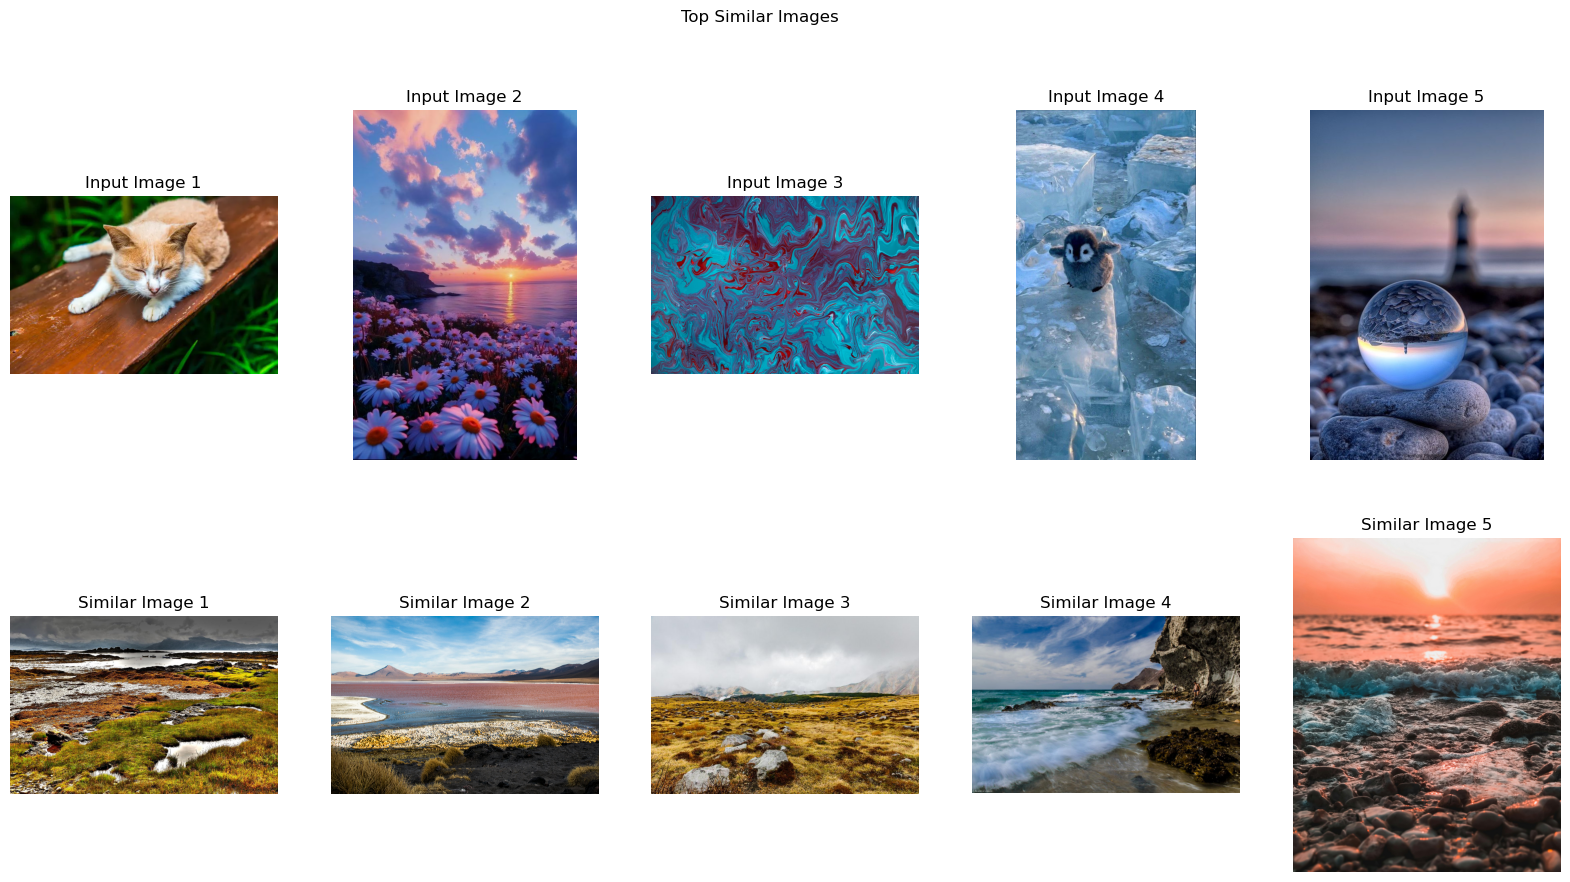

Images plotted.


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sqlite3
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import torch
from torchvision import models, transforms
from PIL import Image
import pickle

# Load pre-trained ResNet model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove the last layer
model.eval()

# Define image preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_embeddings_in_batches(file_path, batch_size):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    uuids = list(data.keys())
    embeddings = list(data.values())
    for i in range(0, len(embeddings), batch_size):
        yield uuids[i:i + batch_size], embeddings[i:i + batch_size]

def compute_embedding(img_path, model):
    img = Image.open(img_path).convert('RGB')
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        embedding = model(img_tensor)
    embedding = embedding.view(-1).numpy()  # Flatten the embedding
    return embedding

def compute_multiple_embeddings(img_paths, model):
    embeddings = []
    for img_path in img_paths:
        embedding = compute_embedding(img_path, model)
        embeddings.append(embedding)
    return np.mean(embeddings, axis=0)  # Average the embeddings

def find_top_similar_images(embedding, embeddings_batches, pca, top_n=5):
    embedding_pca = pca.transform([embedding])
    all_similarities = []
    all_uuids = []
    
    for uuids_batch, embeddings_batch in embeddings_batches:
        similarities = cosine_similarity(embedding_pca, embeddings_batch)[0]
        all_similarities.extend(similarities)
        all_uuids.extend(uuids_batch)
    
    all_similarities = np.array(all_similarities)
    top_indices = all_similarities.argsort()[-top_n:][::-1]
    return [all_uuids[i] for i in top_indices]

def load_image_paths_from_db(db_path, uuids):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    placeholders = ', '.join(['?'] * len(uuids))
    query = f"SELECT uuid, file_path FROM images WHERE uuid IN ({placeholders})"
    cursor.execute(query, uuids)
    rows = cursor.fetchall()
    conn.close()
    return {row[0]: row[1] for row in rows}

def plot_images(main_image_paths, top_similar_images_paths):
    num_input_images = len(main_image_paths)
    fig, axes = plt.subplots(2, max(num_input_images, len(top_similar_images_paths)), figsize=(20, 10))

    for i, img_path in enumerate(main_image_paths):
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        axes[0, i].imshow(img)
        axes[0, i].set_title(f'Input Image {i+1}')
        axes[0, i].axis('off')

    for i, img_path in enumerate(top_similar_images_paths):
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        axes[1, i].imshow(img)
        axes[1, i].set_title(f'Similar Image {i+1}')
        axes[1, i].axis('off')

    plt.suptitle('Top Similar Images')
    plt.show()

# Example usage
input_image_paths = ["new_images/try.jpg","new_images/view.jpg","new_images/texture.jpg","new_images/pengu.jpg","new_images/new_try2.jpg"]  # Paths to the input images
pca_embeddings_path = "pca_embeddings.pkl"  # Path to PCA-reduced dataset embeddings
pca_model_path = "pca_model.pkl"  # Path to the saved PCA model
database_path = "image_metadata.db"  # Path to the database
batch_size = 1000  # Adjust batch size according to memory capacity

# Load PCA model
with open(pca_model_path, 'rb') as f:
    pca = pickle.load(f)

# Compute embedding for the new image(s)
if len(input_image_paths) > 1:
    print(f"Computing embeddings for the new images: {input_image_paths}")
    new_image_embedding = compute_multiple_embeddings(input_image_paths, model)
    print("Embeddings computed.")
else:
    print(f"Computing embedding for the new image: {input_image_paths[0]}")
    new_image_embedding = compute_embedding(input_image_paths[0], model)
    print("Embedding computed.")

# Load embeddings in batches and find top similar images
print("Finding top similar images...")
embeddings_batches = load_embeddings_in_batches(pca_embeddings_path, batch_size)
top_similar_images = find_top_similar_images(new_image_embedding, embeddings_batches, pca)
print(f"Top similar images: {top_similar_images}")

# Load image paths from the database
print("Loading image paths from the database...")
image_paths_dict = load_image_paths_from_db(database_path, top_similar_images)
print(f"Image paths loaded: {image_paths_dict}")

# Get the paths for the similar images
top_similar_images_paths = [image_paths_dict[uuid] for uuid in top_similar_images]
print(f"Top similar images paths: {top_similar_images_paths}")

# Plot the images
print("Plotting images...")
plot_images(input_image_paths, top_similar_images_paths)
print("Images plotted.")


In [ ]:
import pickle
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm

def load_from_pickle(file_path):
    if os.path.exists(file_path):
        with open(file_path, 'rb') as f:
            return pickle.load(f)
    else:
        print(f"File not found: {file_path}")
        return {}

def fetch_image_paths_from_db(db_path, uuids, batch_size=1000):
    image_paths = {}
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    for i in range(0, len(uuids), batch_size):
        batch_uuids = uuids[i:i + batch_size]
        placeholders = ', '.join('?' for _ in batch_uuids)
        query = f"SELECT uuid, file_path FROM images WHERE uuid IN ({placeholders})"
        cursor.execute(query, batch_uuids)
        rows = cursor.fetchall()
        image_paths.update({uuid: file_path for uuid, file_path in rows})
    
    conn.close()
    return image_paths

def apply_umap(embeddings, n_neighbors=15, min_dist=0.1, n_components=3, metric='euclidean'):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric=metric)
    umap_embeddings = reducer.fit_transform(embeddings)
    return umap_embeddings

def apply_tsne(embeddings, n_components=2, perplexity=30, learning_rate=200, n_jobs=-1, n_iter=1000):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate, n_jobs=n_jobs, n_iter=n_iter)
    tsne_embeddings = tsne.fit_transform(embeddings)
    return tsne_embeddings

def plot_embeddings_3d(embeddings, labels, title='3D Embeddings Visualization'):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=labels, cmap='Spectral', s=5)
    plt.colorbar(sc)
    plt.title(title)
    plt.show()

def plot_embeddings_2d(embeddings, labels, title='2D Embeddings Visualization'):
    plt.figure(figsize=(10, 10))
    sc = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='Spectral', s=5)
    plt.colorbar(sc)
    plt.title(title)
    plt.show()

def calculate_silhouette_score(embeddings, labels):
    score = silhouette_score(embeddings, labels)
    print(f'Silhouette Score: {score}')

def calculate_kmeans_clusters(embeddings, n_clusters, batch_size=1000):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size)
    kmeans_labels = kmeans.fit_predict(embeddings)
    return kmeans_labels

if __name__ == "__main__":
    pca_embeddings_path = "pca_embeddings_image_analysis.pkl"  # Path to PCA-reduced dataset embeddings
    db_path = "image_metadata.db"  # Path to the database containing image paths

    # Load PCA-reduced embeddings
    print("Loading PCA-reduced embeddings...")
    embeddings_dict = load_from_pickle(pca_embeddings_path)
    if not embeddings_dict:
        print("The embeddings dictionary is empty. Please check the embeddings file.")
    else:
        uuids, embeddings = zip(*embeddings_dict.items())
        embeddings = np.array(embeddings)
        labels = range(len(embeddings))  # Dummy labels for visualization

        print(f"Loaded {len(embeddings)} embeddings.")

        # Apply UMAP
        print("Applying UMAP...")
        umap_embeddings = apply_umap(embeddings, n_components=3)
        print("UMAP applied.")

        # Fetch image paths from the database
        print("Fetching image paths from the database...")
        images_dict = fetch_image_paths_from_db(db_path, uuids)
        if not images_dict:
            print("The image paths dictionary is empty. Please check the database.")
        else:
            images = [images_dict[uuid] for uuid in uuids if uuid in images_dict]
            print(f"Fetched {len(images)} image paths.")

            # Ensure the number of images matches the number of embeddings
            if len(images) != len(embeddings):
                print("Mismatch between number of embeddings and images.")
            else:
                # Plot UMAP embeddings in 3D
                print("Plotting UMAP 3D embeddings...")
                plot_embeddings_3d(umap_embeddings, labels, title='UMAP 3D Visualization')

                # Apply MiniBatchKMeans clustering on UMAP embeddings
                print("Clustering UMAP embeddings with MiniBatchKMeans...")
                umap_kmeans_labels = calculate_kmeans_clusters(umap_embeddings, n_clusters=10)

                # Calculate Silhouette Score for UMAP embeddings
                print("Calculating Silhouette Score for UMAP embeddings...")
                calculate_silhouette_score(umap_embeddings, umap_kmeans_labels)

        # Apply t-SNE (Optional for 2D)
        print("Applying t-SNE...")
        tsne_embeddings = apply_tsne(embeddings, n_components=2)
        print("t-SNE applied.")

        # Plot t-SNE embeddings in 2D
        print("Plotting t-SNE 2D embeddings...")
        plot_embeddings_2d(tsne_embeddings, labels, title='t-SNE 2D Visualization')

        # Apply MiniBatchKMeans clustering on t-SNE embeddings
        print("Clustering t-SNE embeddings with MiniBatchKMeans...")
        tsne_kmeans_labels = calculate_kmeans_clusters(tsne_embeddings, n_clusters=10)

        # Calculate Silhouette Score for t-SNE embeddings
        print("Calculating Silhouette Score for t-SNE embeddings...")
        calculate_silhouette_score(tsne_embeddings, tsne_kmeans_labels)


Loading PCA-reduced embeddings...
Loaded 444668 embeddings.
Applying UMAP...
UMAP applied.
Fetching image paths from the database...
Fetched 444668 image paths.
Plotting UMAP 3D embeddings...


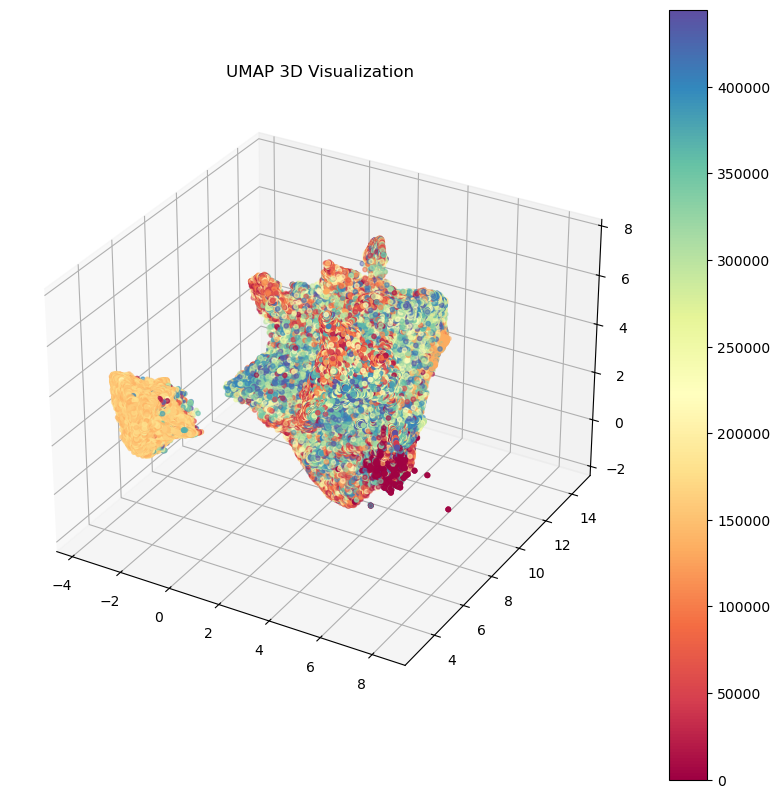

Clustering UMAP embeddings with MiniBatchKMeans...


c:\Users\Lupo\anaconda3\envs\big_data\lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4



Calculating Silhouette Score for UMAP embeddings...


KeyboardInterrupt: 

In [56]:
import pickle
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import umap.umap_ as umap
from sklearn.cluster import MiniBatchKMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

def load_from_pickle(file_path):
    if os.path.exists(file_path):
        with open(file_path, 'rb') as f:
            return pickle.load(f)
    else:
        print(f"File not found: {file_path}")
        return {}

def fetch_image_paths_from_db(db_path, uuids, batch_size=1000):
    image_paths = {}
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    for i in range(0, len(uuids), batch_size):
        batch_uuids = uuids[i:i + batch_size]
        placeholders = ', '.join('?' for _ in batch_uuids)
        query = f"SELECT uuid, file_path FROM images WHERE uuid IN ({placeholders})"
        cursor.execute(query, batch_uuids)
        rows = cursor.fetchall()
        image_paths.update({uuid: file_path for uuid, file_path in rows})
    
    conn.close()
    return image_paths

def apply_umap(embeddings, n_neighbors=15, min_dist=0.1, n_components=3, metric='euclidean'):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric=metric)
    umap_embeddings = reducer.fit_transform(embeddings)
    return umap_embeddings

def plot_embeddings_3d(embeddings, labels, title='3D Embeddings Visualization'):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=labels, cmap='Spectral', s=10)
    plt.colorbar(sc)
    plt.title(title)
    plt.show()

def calculate_silhouette_score(embeddings, labels):
    score = silhouette_score(embeddings, labels)
    print(f'Silhouette Score: {score}')

def calculate_kmeans_clusters(embeddings, n_clusters, batch_size=1000):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size)
    kmeans_labels = kmeans.fit_predict(embeddings)
    return kmeans_labels

def apply_dbscan(embeddings, eps=0.5, min_samples=10):
    # Standardize features before applying DBSCAN
    embeddings = StandardScaler().fit_transform(embeddings)
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(embeddings)
    return dbscan_labels

if __name__ == "__main__":
    pca_embeddings_path = "pca_embeddings.pkl"  # Path to PCA-reduced dataset embeddings
    db_path = "image_metadata.db"  # Path to the database containing image paths

    # Load PCA-reduced embeddings
    print("Loading PCA-reduced embeddings...")
    embeddings_dict = load_from_pickle(pca_embeddings_path)
    if not embeddings_dict:
        print("The embeddings dictionary is empty. Please check the embeddings file.")
    else:
        uuids, embeddings = zip(*embeddings_dict.items())
        embeddings = np.array(embeddings)
        labels = range(len(embeddings))  # Dummy labels for visualization

        print(f"Loaded {len(embeddings)} embeddings.")

        # Apply UMAP
        print("Applying UMAP...")
        umap_embeddings = apply_umap(embeddings, n_components=3)
        print("UMAP applied.")

        # Fetch image paths from the database
        print("Fetching image paths from the database...")
        images_dict = fetch_image_paths_from_db(db_path, uuids)
        if not images_dict:
            print("The image paths dictionary is empty. Please check the database.")
        else:
            images = [images_dict[uuid] for uuid in uuids if uuid in images_dict]
            print(f"Fetched {len(images)} image paths.")

            # Ensure the number of images matches the number of embeddings
            if len(images) != len(embeddings):
                print("Mismatch between number of embeddings and images.")
            else:
                # Plot UMAP embeddings in 3D
                print("Plotting UMAP 3D embeddings...")
                plot_embeddings_3d(umap_embeddings, labels, title='UMAP 3D Visualization')

                # Apply MiniBatchKMeans clustering on UMAP embeddings
                print("Clustering UMAP embeddings with MiniBatchKMeans...")
                umap_kmeans_labels = calculate_kmeans_clusters(umap_embeddings, n_clusters=20)

                # Calculate Silhouette Score for UMAP embeddings
                print("Calculating Silhouette Score for UMAP embeddings...")
                calculate_silhouette_score(umap_embeddings, umap_kmeans_labels)

                # Apply DBSCAN clustering on UMAP embeddings
                print("Clustering UMAP embeddings with DBSCAN...")
                umap_dbscan_labels = apply_dbscan(umap_embeddings)

                # Calculate Silhouette Score for UMAP embeddings with DBSCAN
                print("Calculating Silhouette Score for UMAP embeddings with DBSCAN...")
                calculate_silhouette_score(umap_embeddings, umap_dbscan_labels)

                # Plot DBSCAN results (only for non-noise points)
                non_noise_mask = umap_dbscan_labels != -1
                plot_embeddings_3d(umap_embeddings[non_noise_mask], umap_dbscan_labels[non_noise_mask], title='UMAP 3D Visualization with DBSCAN')

                # Count the number of clusters and noise points
                num_clusters = len(set(umap_dbscan_labels)) - (1 if -1 in umap_dbscan_labels else 0)
                num_noise_points = list(umap_dbscan_labels).count(-1)
                print(f"Number of clusters: {num_clusters}")
                print(f"Number of noise points: {num_noise_points}")
